# Regularisation for poly classifiers and neural network

We look at the effect of Tikhonov regularisation for a polynomial classifier and a neural network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import zero_one_loss
import tensorflow as tf # only for progress bar -- if that is removed, the import can be deleted
plt.style.use("seaborn-v0_8")

2024-02-19 14:57:58.263286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## the data

We pick the well-known iris dataset for this experiment. While fairly boring and over-used, the dataset is quite sufficient for our purposes here.

In [2]:
## load iris data set 
## see https://en.wikipedia.org/wiki/Iris_flower_data_set
from sklearn.datasets import load_iris
iris=load_iris()
X=iris.data
y=iris.target

## For information on the dataset uncomment next line
#print(iris.DESCR)

We pick a rediculously small training set, so that each classifier can strongly overfit -- unless prevented to do so by regularisation.

In [3]:
train_size=20
# we're nasty and only provide three of the four features to the classifiers
X, y = sklearn.utils.shuffle(X[:,:3],y)

Let's plot the dataset.

Text(0, 0.5, 'sepal width')

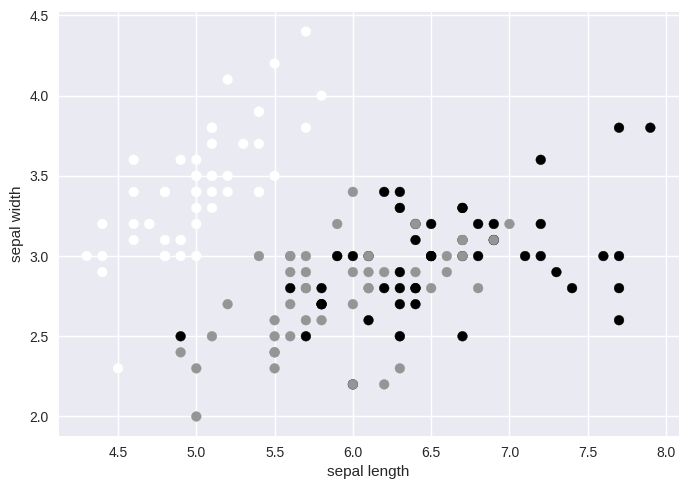

In [4]:
_,ax=plt.subplots()
ax.scatter(X[:,0],X[:,1],c=y)
ax.set_xlabel("sepal length")
ax.set_ylabel("sepal width")

## The experiments

The test code. We repeat every experiments a number of times (repeats) to get some statistical stability. In each repetition the data set is randomly shuffled, the training set chosen and the classifiers of different regularisation strengths are fitted and tested. Averages of training and test error are returned.

In [5]:
def average_over_repeats(classifiers,repeats):
    train_errs=[]
    test_errs=[]
    
    ## this is just for visual feedback in the main loop as it may take a while to finish
    progbar = tf.keras.utils.Progbar(repeats)
    progbar.update(0)    
    
    for i in range(repeats):
        current_train_errs=[]
        current_test_errs=[]
        train_errs.append(current_train_errs)
        test_errs.append(current_test_errs)
        XX, yy = sklearn.utils.shuffle(X,y)
        X_train, X_test = XX[:train_size], XX[train_size:]
        y_train, y_test = yy[:train_size], yy[train_size:]
        for classifier in classifiers:
            classifier.fit(X_train,y_train)
            train_err=zero_one_loss(y_train,classifier.predict(X_train))
            test_err=zero_one_loss(y_test,classifier.predict(X_test))
            current_train_errs.append(train_err)
            current_test_errs.append(test_err)
        progbar.update(i+1)  ## again just for the progress bar
    mean_train_err_by_classifier=np.mean(train_errs,axis=0)
    mean_test_err_by_classifier=np.mean(test_errs,axis=0)
    return mean_train_err_by_classifier,mean_test_err_by_classifier
    
def plot_averages(mean_train_errs,mean_test_errs,regularisation_strengths,title):
    fig,axs=plt.subplots(1,2,figsize=(12,4))
    axs[0].plot(regularisation_strengths,mean_train_errs,'bo-',label='train errors')
    axs[0].set_ylim(bottom=0)
    axs[1].plot(regularisation_strengths,mean_test_errs,'ro-',label='test errors')
    axs[0].set_title(title)
    axs[1].set_title(title)
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].legend()
    axs[1].legend()
    axs[0].set_xlabel('regularisation strength')
    axs[1].set_xlabel('regularisation strength')
    axs[0].set_ylim(bottom=0)
    axs[1].set_ylim(bottom=0)
    plt.show()

### Logistic Regression

We train a polynomial classifier with degree 7. As the training set has size 20, this is a massive overfit. 

In *scikit-learn* a polynomial classifier is realised by first generating <code>PolynomialFeatures</code> that are then passed to a logistical regression. With the help of a <code>Pipeline</code>, we can glue these two classes together so that they behave as a single classifier. This means we can run the same test code for the polynomial classifiers and the neural networks later on.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import sklearn.pipeline

regularisation_strengths=[10,100,1000,10000,100000]
poly_classifiers=[]
for reg_strength in regularisation_strengths:
    # for some reason, parameter C is _inverse_ of regularisation strength 
    logreg=LogisticRegression(solver='lbfgs',C=1/reg_strength,max_iter=10000)
    poly=PolynomialFeatures(degree=7)
    # now we plug the PolynomialFeatures transformer into the LogisticRegression via a pipeline
    # when pipe.fit is called it will first execute the PolynomialFeatures transformer and then fit the result with LogisticRegression
    pipe = sklearn.pipeline.Pipeline([('poly features', poly), ('logreg',logreg)])
    poly_classifiers.append(pipe)

200/200 [==============================] - 29s 147ms/step


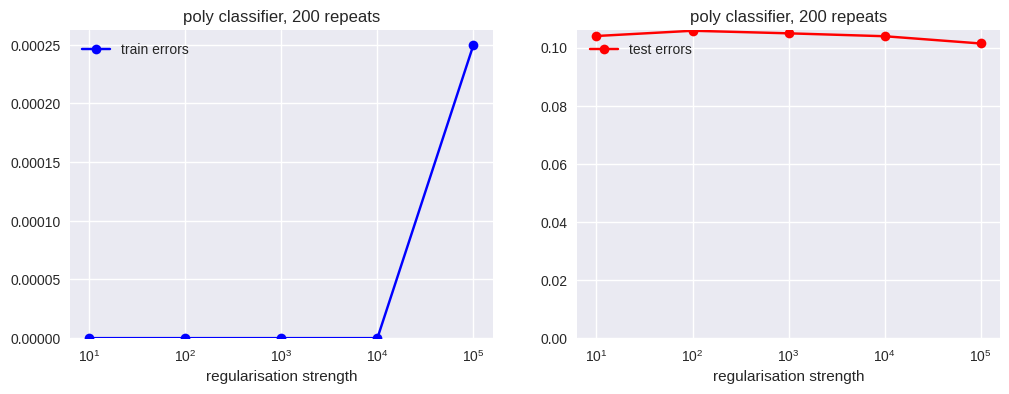

In [7]:
repeats=200
train_errs,test_errs=average_over_repeats(poly_classifiers,repeats)
plot_averages(train_errs,test_errs,regularisation_strengths,"poly classifier, {} repeats".format(repeats))

We see: we can counteract the massive overfit somewhat by imposing massive regularisation. (Obviously, it would be much saner here to simply use a smaller degree.)

### Neural network

Let's do this again, but this time with a neural network. Note, here I am using the implementation of *scikit-learn* -- it would be more professional to use *tensorflow*. For our purposes, however, *scikit-learn* will do. We train networks with two hidden layers, one with 50 units and one with 20 units. Again, quite an overfit.

In [8]:
from sklearn.neural_network import MLPClassifier

regularisation_strengths_NN=[0.001,0.01,0.1,0.5,1,2]
net_classifiers=[]
for reg_strength in regularisation_strengths_NN:
    net=MLPClassifier(hidden_layer_sizes=(50,20),max_iter=3000,alpha=reg_strength)
    net_classifiers.append(net)

100/100 [==============================] - 236s 2s/step


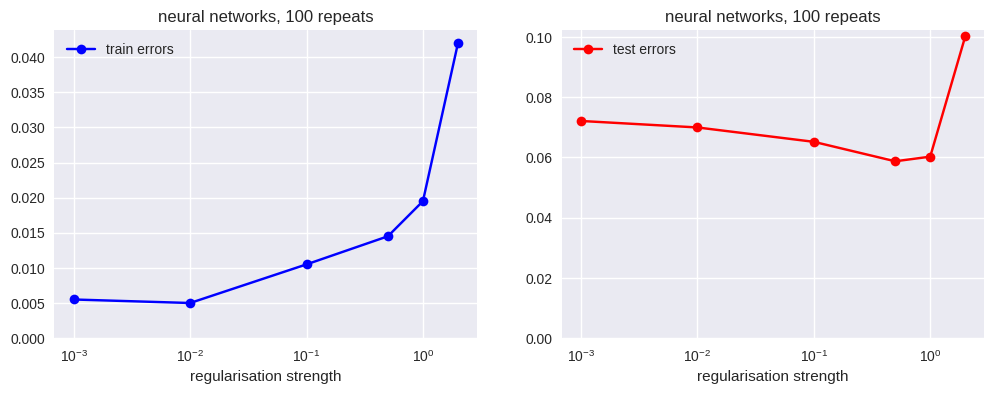

In [9]:
repeats=100
train_errs_NN,test_errs_NN=average_over_repeats(net_classifiers,repeats)
plot_averages(train_errs_NN,test_errs_NN,regularisation_strengths_NN,"neural networks, {} repeats".format(repeats))

I am bit mystified by this result. On the one hand, the two curves fit quite well: first increasing regularisation prevents overfitting more and more, which leads to lower test error; then training error shoots up as too strong regularisation hampers learning of the training set, and this then results in increasing test error. On the other hand, I am surprised that this neural network cannot learn the training set perfectly, even with small regularisation. 